In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy.stats.kde import gaussian_kde
from numpy import linspace
from src.fewshot_ner_viz_component.fewshot_ner_binary_classifier import FewshotNerBinaryClassifier, CompositeEmbedder
from src.fewshot_ner_viz_component.data_processing import *

/home/kostrovskiy/prog/AI/NLP/DeepPavlov/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
2018-08-17 18:01:46.185 DEBU

In [2]:
dataset_orig = read_data()

Num of train sentences: 75187
Num of valid sentences: 9603
Num of test sentences: 9479
[(['Actions', 'had', 'to', 'be', 'taken', 'to', 'break', 'through', 'the', 'blockade', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'a', 'night', 'in', 'late', 'July', '1940', ',', 'the', 'atmosphere', 'in', 'Zhuanbi', 'Village', 'in', 'Shaanxi', 'was', 'unusual', '.'], ['O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-GPE', 'I-GPE', 'O', 'B-GPE', 'O', 'O', 'O']), (['Villager', 'Xiao', 'Jianghe', 'has', 'a', 'vivid', 'memory', 'of', 'this', 'piece', 'of', 'history', '.'], ['O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'that', 'dark', 'night', ',', 'everyone', 'was', 'sleeping', 'when', 'human', 'voices', 'and', 'neighing', 'horses', 'were', 'heard', 'within', 'the', 'village', '.'], ['O', 'B-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [3]:
ne_type = 'PERSON'
dataset = filter_dataset_by_ne_types(dataset_orig, ne_type)

Num of train sentences: 12195
Num of valid sentences: 1553
Num of test sentences: 1573


In [4]:
embedder = CompositeEmbedder(use_elmo=True, elmo_scale=1, cap_scale=1, use_cap_feat=False, use_glove=False)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


2018-08-17 18:01:59.119 INFO in 'tensorflow'['tf_logging'] at line 160: Using /tmp/tfhub_modules to cache modules.


INFO:tensorflow:Initialize variable module/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


2018-08-17 18:01:59.509 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


INFO:tensorflow:Initialize variable module/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


2018-08-17 18:01:59.516 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


2018-08-17 18:01:59.524 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


2018-08-17 18:01:59.531 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


2018-08-17 18:01:59.538 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


2018-08-17 18:01:59.547 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


2018-08-17 18:01:59.553 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


2018-08-17 18:01:59.562 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


2018-08-17 18:01:59.570 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


2018-08-17 18:01:59.577 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


2018-08-17 18:01:59.585 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


2018-08-17 18:01:59.593 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


2018-08-17 18:01:59.601 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


2018-08-17 18:01:59.610 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


2018-08-17 18:01:59.619 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


INFO:tensorflow:Initialize variable module/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


2018-08-17 18:01:59.628 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


INFO:tensorflow:Initialize variable module/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


2018-08-17 18:01:59.635 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


INFO:tensorflow:Initialize variable module/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


2018-08-17 18:01:59.643 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


INFO:tensorflow:Initialize variable module/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


2018-08-17 18:01:59.651 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


INFO:tensorflow:Initialize variable module/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


2018-08-17 18:01:59.659 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


INFO:tensorflow:Initialize variable module/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


2018-08-17 18:01:59.666 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


INFO:tensorflow:Initialize variable module/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


2018-08-17 18:01:59.676 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


INFO:tensorflow:Initialize variable module/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


2018-08-17 18:01:59.685 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


INFO:tensorflow:Initialize variable module/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


2018-08-17 18:01:59.693 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


INFO:tensorflow:Initialize variable module/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


2018-08-17 18:01:59.702 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


INFO:tensorflow:Initialize variable module/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


2018-08-17 18:01:59.712 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


2018-08-17 18:01:59.720 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


2018-08-17 18:01:59.726 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


2018-08-17 18:01:59.732 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


2018-08-17 18:01:59.740 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


2018-08-17 18:01:59.747 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


2018-08-17 18:01:59.757 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


2018-08-17 18:01:59.770 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


2018-08-17 18:01:59.777 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


2018-08-17 18:01:59.784 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


2018-08-17 18:01:59.791 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


2018-08-17 18:01:59.798 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


2018-08-17 18:01:59.807 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed


2018-08-17 18:01:59.815 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed


In [5]:
def get_matrices(tokens, tags, embedder):
    return (embeddings2feat_mat(embedder.embed(tokens), get_tokens_len(tokens)), 
           tags2binaryFlat(tags))

In [6]:
def get_batch(dataset, embedder):
    n_support_sen = 10
    n_query_sen = 10
    n_samples = n_support_sen + n_query_sen
    tokens, tags = get_data_sample(dataset['train'], n_support_sen + n_samples)
    tokens_support = tokens[:n_support_sen]
    tags_support = tags[:n_support_sen]
    tokens_query = tokens[n_support_sen:]
    tags_query = tags[n_support_sen:]
    X_support, y_support = get_matrices(tokens_support, tags_support, embedder)
    X_query, y_query = get_matrices(tokens_query, tags_query, embedder)
    return X_support, y_support, X_query, y_query

In [7]:
def encoder(x, params):
#     print('x.shape: {}'.format(x.get_shape()))
    weights =  params['weights']
    biases = params['biases']
#     print('W1.shape: {}'.format(weights[0].get_shape()))
    n_layers = len(weights)
    signals = [None]*(n_layers + 1)
    signals[0] = x
    for i in range(n_layers):
        signals[i+1] = tf.nn.sigmoid(tf.add(tf.matmul(signals[i], weights[i], transpose_b=True), biases[i]))
    out = signals[-1]
    return out

In [8]:
def normalize_tf(x):
    return x/tf.tile(tf.expand_dims(tf.norm(x1, axis=-1), axis=-1))
def calc_sim_tf(x1, x2, sim_type='cosine'):
    if sim_type == 'euc_dist':
        return tf.exp(-tf.norm(x1 - x2, axis=-1))
    elif sim_type == 'dot_prod':
        return tf.matmul(x1, x2, transpose_b=True)
    elif sim_type == 'cosine':
        return tf.matmul(tf.nn.l2_normalize(x1, axis=-1), tf.nn.l2_normalize(x2, axis=-1), transpose_b=True)

In [9]:
def build_model(params, X_support, y_support, X_query, y_query, verbose=False):
    
#     if verbose:
#         print('X_support.shape: {}'.format(tf.shape(X_support)))
    
    # Calculate initial similarities
    X_sup_ne = tf.gather(X_support, tf.squeeze(tf.where(tf.equal(y_support, 1))), axis=-2)
    ne_sup_centroid = tf.reduce_mean(X_sup_ne, axis=-2, keepdims=True)
    sims = calc_sim_tf(X_query, ne_sup_centroid, sim_type='cosine')
    n_query_tokens = tf.shape(X_query)[-2]
    sims_ne = tf.squeeze(tf.gather(sims, tf.squeeze(tf.where(tf.equal(y_query, 1))), axis=-2))
    sims_words = tf.squeeze(tf.gather(sims, tf.squeeze(tf.where(tf.equal(y_query, 0))), axis=-2))
    d_sim = tf.reduce_mean(sims_ne) - tf.reduce_mean(sims_words)
    
    # Make encoding
    f_support = encoder(X_support, params)
    f_query = encoder(X_query, params)
    
    f_sup_ne = tf.gather(f_support, tf.squeeze(tf.where(tf.equal(y_support, 1))), axis=-2)
    f_sup_words = tf.gather(f_support, tf.squeeze(tf.where(tf.equal(y_support, 0))), axis=-2)
    
#     if verbose:
#         print('f_sup_ne.shape: {}'.format(tf.shape(f_sup_ne)))
#         print('f_sup_words: {}'.format(tf.shape(f_sup_words)))
    
    ne_sup_centroid_f = tf.reduce_mean(f_sup_ne, axis=-2, keepdims=True)
#     if verbose:
#         print('ne_supp_centroid.shape: {}'.format(tf.shape(ne_supp_centroid)))
    
    f_query = encoder(X_query, params)
    
    sim_ne_centroid_f = calc_sim_tf(f_query, ne_sup_centroid_f, sim_type='cosine')
    sim_words_f = calc_sim_tf(f_query, f_sup_words, sim_type='cosine')
    
    objective = tf.squeeze(sim_ne_centroid_f) - tf.reduce_mean(tf.squeeze(sim_words_f), axis=-1)
    
    loss = tf.reduce_mean((1-2*y_query)*objective)
    
    sim_q_cent_ne_f = tf.gather(sim_ne_centroid_f, tf.squeeze(tf.where(tf.equal(y_query, 1))), axis=-2)
    sim_q_cent_words_f = tf.gather(sim_ne_centroid_f, tf.squeeze(tf.where(tf.equal(y_query, 0))), axis=-2)
    d_sim_f = tf.reduce_mean(tf.squeeze(sim_q_cent_ne_f)) - tf.reduce_mean(tf.squeeze(sim_q_cent_words_f))
    
    return loss, d_sim, d_sim_f

In [10]:
n_input = 1024
n_hidden1 = 512
n_output = 256

weights = [tf.get_variable(name='h1', shape=(n_hidden1, n_input), initializer=tf.contrib.layers.xavier_initializer()),
            tf.get_variable(name='w_out', shape=(n_output, n_hidden1), initializer=tf.contrib.layers.xavier_initializer())]
biases = [tf.get_variable(name='b1', shape=(n_hidden1), initializer=tf.contrib.layers.xavier_initializer()),
            tf.get_variable(name='b_out', shape=(n_output), initializer=tf.contrib.layers.xavier_initializer())]

params = {'weights': weights, 'biases': biases}

X_support = tf.placeholder('float', [None, n_input])
y_support = tf.placeholder('float', [None])
X_query = tf.placeholder('float', [None, n_input])
y_query = tf.placeholder('float', [None])

### Train model

In [11]:
n_epochs = 5
n_steps = 10
loss, d_sim, d_sim_f = build_model(params, X_support, y_support, X_query, y_query)
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)
sess = tf.Session()
sess.run(tf.initialize_all_variables())
for epoch in range(n_epochs):
    print('Epoch {}'.format(epoch+1))
    for step in range(n_steps):
        X_support_batch, y_support_batch, X_query_batch, y_query_batch = get_batch(dataset, embedder)
#         print(X_support_batch.shape)
#         print(X_query_batch.shape)
        print('Step {}/{}'.format(step+1, n_steps))
        feed = {X_support: X_support_batch, y_support: y_support_batch, X_query: X_query_batch, y_query: y_query_batch}
        _, loss_cur, d_sim_cur, d_sim_f_cur = sess.run([train_op, loss, d_sim, d_sim_f], feed_dict=feed)
    print('train loss = {}, d_sim = {}, d_sim_f = {}'.format(loss_cur, d_sim_cur, d_sim_f_cur))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


2018-08-17 18:02:01.293 WARNING in 'tensorflow'['tf_logging'] at line 126: From /home/kostrovskiy/prog/AI/NLP/DeepPavlov/env/lib/python3.6/site-packages/tensorflow/python/util/tf_should_use.py:118: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Epoch 1
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10
train loss = -0.12821468710899353, d_sim = 0.2500569224357605, d_sim_f = 0.12866801023483276
Epoch 2
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10
train loss = -0.6350966691970825, d_sim = 0.2501527667045593, d_sim_f = 0.6383853554725647
Epoch 3
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10
train loss = -0.8083118796348572, d_sim = 0.26125359535217285, d_sim_f = 0.7851938009262085
Epoch 4
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10
train loss = -0.9504573345184326, d_sim = 0.21387189626693726, d_sim_f = 0.8881150484085083
Epoch 5
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10
train loss = -0.9610115885734558, d_sim = 0.25458425283432007, d_sim_f = 0.948635101318

### Test model

In [27]:
data_test = {}
tokens, tags = get_data_sample(dataset['test'], 10)
data_test['support'] = (tokens, tags)
tokens, tags = get_data_sample(dataset['test'], 100)
data_test['query'] = (tokens, tags)
print(len(data_test['support'][0]))
print(len(data_test['query'][0]))

10
100


In [28]:
X_test_s, y_test_s = get_matrices(data_test['support'][0], data_test['support'][1], embedder)
X_test_q, y_test_q = get_matrices(data_test['query'][0], data_test['query'][1], embedder)

In [29]:
print(X_test_s.shape)
print(X_test_q.shape)

(152, 1024)
(2224, 1024)


In [30]:
# Apply encoder
x = tf.placeholder('float', [None, n_input])
X_enc_s = sess.run([encoder(x, params)], {x: X_test_s})[0] 
X_enc_q = sess.run([encoder(x, params)], {x: X_test_q})[0]
print(X_enc_s.shape)
print(X_enc_q.shape)

(152, 256)
(2224, 256)


In [31]:
def normalize(x: np.ndarray):
    return x/np.tile(np.expand_dims(np.linalg.norm(x, axis=-1), axis=-1), x.shape[-1])
def calc_sim(x1: np.ndarray, x2: np.ndarray, sim_type='cosine'):
    if sim_type == 'euc_dist':
        return np.exp(-np.linalg.norm(x1 - x2, axis=-1))
    elif sim_type == 'dot_prod':
        return np.dot(x1, x2.T)
    elif sim_type == 'cosine':
        return np.dot(normalize(x1), normalize(x2).T)

In [32]:
def calc_sim_ne_centroid(X_support, y_support, X_query):
    X_sup_ne = X_support[y_support == 1, :]
    X_sup_words = X_support[y_support == 0, :]
    ne_sup_centroid = np.mean(X_sup_ne, axis=0)
    sim_q_list = calc_sim(X_query, ne_sup_centroid, sim_type='cosine')
    return sim_q_list

In [33]:
def plotPDE(sims, y, info=''):
    sims_words = sims[y == 0]
    sims_ne = sims[y == 1]
    plt.figure(figsize=(7,5))
    kde_words = gaussian_kde(sims_words)
    dist_space_words = linspace(min(sims_words), max(sims_words), 100)
    kde_ne = gaussian_kde( sims_ne )
    dist_space_ne = linspace(min(sims_ne), max(sims_ne), 100)
    plt.plot( dist_space_words, kde_words(dist_space_words), color='green', label='words' )
    plt.plot( dist_space_ne, kde_ne(dist_space_ne), color='red',  label='named entities' )
    plt.legend(loc='upper right')
    plt.title('Cosine NE similarity PDE ({})'.format(info))
    plt.grid()

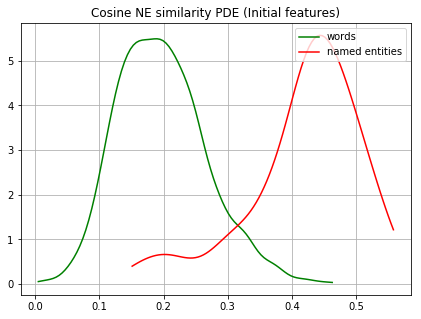

In [34]:
sims_orig = calc_sim_ne_centroid(X_test_s, y_test_s, X_test_q)
plotPDE(sims_orig, y_test_q, 'Initial features')

In [35]:
y_pred_orig = np.zeros(y_test_q.size)
y_pred_orig[sims_orig > 0.3] = 1
f1_orig = f1_score(y_test_q, y_pred_orig)
print('F1 score = {:.2f}'.format(f1_orig*100))

F1 score = 66.79


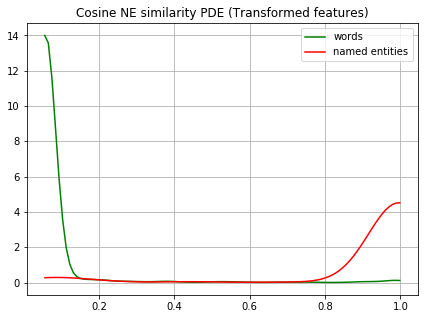

In [36]:
sims_enc = calc_sim_ne_centroid(X_enc_s, y_test_s, X_enc_q)
plotPDE(sims_enc, y_test_q, 'Transformed features')

In [42]:
y_pred_enc = np.zeros(y_test_q.size)
y_pred_enc[sims_enc > 0.5] = 1
f1_enc = f1_score(y_test_q, y_pred_enc)
print('F1 score = {:.2f}'.format(f1_enc*100))

F1 score = 86.24
